# MCBDD 2023 Module II offline activity 

Jitao David Zhang, May 2023

All the analysis below was done with python 3.8.5 using conda version 4.10.1.


## Task 1

Retrieve all approved drugs from the ChEMBL database, sort them by approval year and name. 

The following steps examine the first approval year and names of drugs, and fill a DataFrame with these information. While the first approval year is almost uniquely defined, a drug can have many names. For consistency, we use the INN (international nonproprietary names). See [chembl_webresource_client](https://github.com/chembl/chembl_webresource_client) for more examples.

In [1]:
from chembl_webresource_client.new_client import new_client
import requests
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
drugs = new_client.drug
len(drugs)

14816

In [3]:
drugs[0]

{'applicants': ['Dava Pharmaceuticals Inc',
  'American Therapeutics Inc',
  'Idt Australia Ltd',
  'Watson Laboratories Inc',
  'Pfizer Laboratories Div Pfizer Inc',
  'Ani Pharmaceuticals Inc',
  'Granules Pharmaceuticals Inc',
  'Mylan Pharmaceuticals Inc',
  'Teva Pharmaceuticals Usa',
  'Purepac Pharmaceutical Co'],
 'atc_classification': [{'code': 'C02CA01',
   'description': 'CARDIOVASCULAR SYSTEM: ANTIHYPERTENSIVES: ANTIADRENERGIC AGENTS, PERIPHERALLY ACTING: Alpha-adrenoreceptor antagonists'}],
 'availability_type': 1,
 'biotherapeutic': None,
 'black_box': 0,
 'black_box_warning': '0',
 'chirality': 2,
 'development_phase': '4.0',
 'drug_type': 1,
 'first_approval': 1976,
 'first_in_class': 0,
 'helm_notation': None,
 'indication_class': 'Antihypertensive',
 'molecule_chembl_id': 'CHEMBL2',
 'molecule_properties': {'alogp': '1.78',
  'aromatic_rings': 3,
  'cx_logd': '1.43',
  'cx_logp': '1.65',
  'cx_most_apka': None,
  'cx_most_bpka': '7.24',
  'full_molformula': 'C19H21N5O

In [4]:
def get_chembl(drug: list):
    """ return ChEMBL ID"""
    return drug['molecule_chembl_id']

get_chembl(drugs[0])

'CHEMBL2'

In [5]:
def get_FirstApproval(drug: list):
    """ returns the year of first approval"""
    return drug['first_approval']


get_FirstApproval(drugs[0])

1976

In [6]:
drugs[0]['molecule_synonyms']

[{'molecule_synonym': 'CP-12299',
  'syn_type': 'RESEARCH_CODE',
  'synonyms': 'CP-12299'},
 {'molecule_synonym': 'CP-122991',
  'syn_type': 'RESEARCH_CODE',
  'synonyms': 'CP-122991'},
 {'molecule_synonym': 'Prazosin', 'syn_type': 'FDA', 'synonyms': 'Prazosin'},
 {'molecule_synonym': 'Prazosin', 'syn_type': 'ATC', 'synonyms': 'PRAZOSIN'},
 {'molecule_synonym': 'Prazosin', 'syn_type': 'BAN', 'synonyms': 'PRAZOSIN'},
 {'molecule_synonym': 'Prazosin', 'syn_type': 'INN', 'synonyms': 'PRAZOSIN'},
 {'molecule_synonym': 'Prazosin',
  'syn_type': 'MERCK_INDEX',
  'synonyms': 'PRAZOSIN'},
 {'molecule_synonym': 'Prazosin', 'syn_type': 'OTHER', 'synonyms': 'PRAZOSIN'}]

In [7]:
def get_INN(drug: list):
    """returns INN name, use ; as concatenator if more than one value is available"""
    inn = [x['molecule_synonym'] for x in drug['molecule_synonyms'] if x['syn_type'] == 'INN']
    res = ';'.join(inn)
    return(res)


get_INN(drugs[0])

'Prazosin'

In [8]:
ids = [get_chembl(x) for x in drugs]
years = [get_FirstApproval(x) for x in drugs]
names = [get_INN(x) for x in drugs]

In [9]:
task1 = pd.DataFrame({'ID':ids, 'Name':names, 'FirstApproval':years})
task1.sort_values(by=['Name', 'FirstApproval'], axis=0, inplace=True)
print(task1)
## notice that not all molecules have INN names or approval information

                  ID               Name  FirstApproval
271         CHEMBL90                            1939.0
1078       CHEMBL821                            1939.0
2922       CHEMBL190                            1940.0
4625   CHEMBL1201649                            1942.0
4333   CHEMBL1201235                            1943.0
...              ...                ...            ...
2484    CHEMBL167779        Zuclomifene            NaN
1327     CHEMBL53904     Zuclopenthixol            NaN
12490  CHEMBL4105630         Zuranolone            NaN
12952  CHEMBL4297637  Zuretinol acetate            NaN
12258  CHEMBL3989838       Zylofuramine            NaN

[14816 rows x 3 columns]


In [10]:
task1.to_csv('20230507-ChEMBL-drugs-sorted-by-name-and-approval.tsv.gz', sep='\t')

## Task 2

For each approved drug since 2013 that you identified in step (1), retrieve a list of UniProt accession numbers, namely protein targets associated with the drug.

We first filter the compounds by the approval year.

In [12]:
approved_s2013_df = task1.query('FirstApproval >= 2013')\
                         .sort_values(by='FirstApproval', axis=0)
print(approved_s2013_df)

                  ID                Name  FirstApproval
402     CHEMBL278020                             2013.0
2905    CHEMBL376359          Alogliptin         2013.0
1929     CHEMBL99946     Levomilnacipran         2013.0
7499   CHEMBL2105689        Luliconazole         2013.0
1149     CHEMBL43452        Pomalidomide         2013.0
...              ...                 ...            ...
13050  CHEMBL4297750           Faricimab         2022.0
13789  CHEMBL4594505         Teclistamab         2022.0
3257    CHEMBL272427  Ursodoxicoltaurine         2022.0
13129  CHEMBL4297832          Sutimlimab         2022.0
13279  CHEMBL4297990         Tebentafusp         2022.0

[453 rows x 3 columns]


Next we query UniProts of targets associated with each drug molecule. The query is done in two steps: first we find ChEMBL identifiers of targets, and then we translate these ChEMBL identifiers to UniProt identifiers.

To save time, I used only the first 50 drugs to produce the example below. Even this is quite slow, taking quite a few minutes to run. You are welcome to use all compounds as input if you are interested in the results. 

Some technical detail: queries are done in so-called chunks, with 25 items in a chunk and therefore we use two chunks in total. The use of chunks help to limite the information transmitted between the server and the client, and thereby reducing both server load and client's waiting time. If you wish to process all compounds, you can use a larger chunk size, for instance 50.

In [13]:
drugs_approved_s2023 = approved_s2013_df.ID[0:50]

comp2target = dict()
for d in drugs_approved_s2023:
    comp2target[d] = set()

# Process compounds in chunks so that we prevent huge queries:
chunk_size = 25
keys = list(comp2target.keys())

for i in range(0, len(keys), chunk_size):
    # we jump from compounds to targets through activities:
    activities = new_client.activity.filter(molecule_chembl_id__in=keys[i:i + chunk_size]).only(
        ['molecule_chembl_id', 'target_chembl_id'])
    # extracting target ChEMBL IDs from activities:
    for act in activities:
        comp2target[act['molecule_chembl_id']].add(act['target_chembl_id'])

# Now our dictionary maps from compound ChEMBL IDs into target ChEMBL IDs
# We next translate the identifier of targets from ChEMBL IDs to UniProt IDs
for key, val in comp2target.items():
    # We don't know how many targets are associated with any compound. Therefore it is
    # better to process targets in chunks, as suggested by the ChEMBL webclient.
    lval = list(val)
    uniprots = set()
    for i in range(0, len(val), chunk_size):
        targets = new_client.target.filter(target_chembl_id__in=lval[i:i + chunk_size]).only(
            ['target_components'])
        uniprots |= {comp['accession'] for t in targets for comp in t['target_components']}

    comp2target[key] = uniprots

In [14]:
comp2target_df = pd.DataFrame([(i, uniprot) for i, j in comp2target.items() for uniprot in j], 
                  columns=['ID','UniProt'])
print(comp2target_df)

                ID UniProt
0     CHEMBL278020  Q92887
1     CHEMBL278020  P81908
2     CHEMBL278020  P33261
3     CHEMBL278020  P02545
4     CHEMBL278020  O15439
...            ...     ...
1674  CHEMBL408513  Q9UKV0
1675  CHEMBL408513  P0DTD1
1676  CHEMBL408513  Q92769
1677  CHEMBL408513  P08684
1678  CHEMBL408513  Q9UQL6

[1679 rows x 2 columns]


Here we report *all* targets, irrespective of assays and affinicities. In reality, you may be more interested in specific targets with high affinities. In such situations, it makes sense to se one or more filters that fit your purpose.

Finally we export the results into a tab-delimited file again.

In [15]:
comp2target_df.to_csv('20230507-ChEMBL-drugs-since-2013-UniProt.tsv.gz', sep='\t')

## Task 3

For each protein with a UniProt accession number that you identified in step (2),retrieve UniProt keywords associated with it.

Again, for the purpose of demonstration, I show the analysis with the first 100 proteins. I used the REST API of UniProt to show how it works, which accepts maximum 100 proteins in one go, that's why I retrieved the keywords of 100 proteins. Similar as what we did before with the ChEMBL database, you can break up big queries into smaller chunks.

You can try to query all other proteins with the same procedure. However, for effective use when you have many identifiers, it may make more sense to bulk-download the keyword data from UniProt and run the analysis.

In [17]:
## read in results of task 2
task2_res = pd.read_csv('20230507-ChEMBL-drugs-since-2013-UniProt.tsv.gz', sep='\t', index_col=0)

In [18]:
uniq_uniprot = set(task2_res.UniProt)
sel_uniprot = list(uniq_uniprot)[:100]
sel_uniprot_queryid = ','.join(sel_uniprot)

In [19]:
## see UniProt API document here: https://www.ebi.ac.uk/proteins/api/doc/#!/proteins/search
url = 'https://www.ebi.ac.uk/proteins/api/proteins?offset=0&size=100&accession='+sel_uniprot_queryid
r = requests.get(url, headers={'Accept': 'application/json'})

In [20]:
## the keywords of the first protein can be found here
keywords = [list(k.values())[0] for k in r.json()[0]['keywords']]
print(keywords)

['Host-virus interaction', 'Membrane', 'Nucleotidyltransferase', 'RNA-directed RNA polymerase', 'Transferase', 'Viral RNA replication']


In [21]:
len(r.json())

100

In [22]:
## now let's try to fetch all keywords
def get_keywords(protein: list):
    res = [list(k.values())[0] for k in protein['keywords']]
    if res == None:
        res = []
    return(res)

all_keywords=[]
for jlist in r.json():
    all_keywords.extend(get_keywords(jlist))
    
keyword_counter = Counter(all_keywords)
print(keyword_counter)

Counter({'Reference proteome': 98, 'Phosphoprotein': 77, 'Nucleotide-binding': 74, '3D-structure': 71, 'ATP-binding': 71, 'Alternative splicing': 69, 'Transferase': 68, 'Kinase': 64, 'Cytoplasm': 56, 'Membrane': 46, 'Serine/threonine-protein kinase': 42, 'Nucleus': 38, 'Cell membrane': 33, 'Disease variant': 32, 'Metal-binding': 31, 'Ubl conjugation': 29, 'Glycoprotein': 28, 'Acetylation': 27, 'Transmembrane': 26, 'Transmembrane helix': 26, 'Tyrosine-protein kinase': 25, 'Direct protein sequencing': 23, 'Repeat': 23, 'Magnesium': 22, 'Signal': 21, 'Disulfide bond': 19, 'Receptor': 19, 'Host-virus interaction': 17, 'Cytoskeleton': 16, 'Apoptosis': 15, 'Cell cycle': 14, 'Cell projection': 12, 'Hydrolase': 12, 'Isopeptide bond': 10, 'Endoplasmic reticulum': 10, 'Transcription': 9, 'Transcription regulation': 9, 'Developmental protein': 9, 'Transport': 9, 'Mitochondrion': 9, 'Intellectual disability': 8, 'Methylation': 8, 'Coiled coil': 8, 'Synapse': 8, 'Endosome': 8, 'Proto-oncogene': 8, 

We visualize the most common 20 keywords with a histogram.

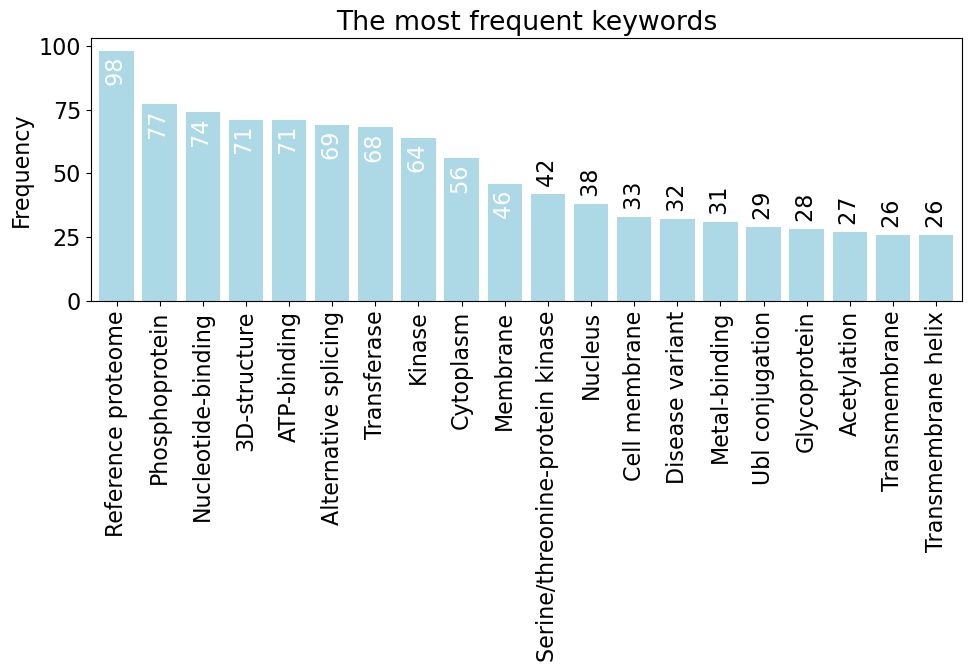

In [23]:
most_common_keywords = keyword_counter.most_common(20)
y = [count for keyword, count in most_common_keywords]
x = [keyword for keyword, count in most_common_keywords]

plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams.update({'font.size': 16})

plt.bar(x, y, color='lightblue')
plt.title("The most frequent keywords")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(most_common_keywords):
    plt.text(i, count, f' {count} ', rotation=90, size=16,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

Note that many proteins are annotated with the keyword 'kinase', the relevant keywords 'phosphoprotein' and 'ATP-binding' (kinase phosphorylates other proteins with ATP), as well as the keyword 'membrane proteins' and relevant concepts such as 'transmembrane'. Recall that GPCRs, ion channels, and kinases are among the frequent classes of drug targets. At the same time, nucleotide-binding, i.e. DNA- or RNA-binding proteins are well present.